In [71]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from glob import glob
import math
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import json
import random
import pandas as pd
from tqdm import tqdm
import trimesh

import torch

from ANALYSIS.analysis_utils import (
    plot_panel_info,
    visualize_meshes_plotly,
    filter_segmentation_map,
    filter_segmentation_map_clusters,
    is_clockwise,
)


import plotly.graph_objects as go

from env_constants import SEWFORMER_PROJ_ROOT, DATASET_ROOT, PYGARMENT_ROOT

sys.path.append(PYGARMENT_ROOT)

import pygarment as pyg

In [2]:
garment_df = pd.read_csv("garment_df_20250215_165422.csv")

filtered_combination_name_list = np.unique(garment_df[
    garment_df["mesh_filter_failed"] == False
]["matching_combination_name"]).tolist()

filtered_combination_path_list = list(map(
    lambda x : os.path.join(DATASET_ROOT, 'sewfactory', x),
    filtered_combination_name_list
))

In [3]:
import json
import numpy as np
import smplx
import torch
import trimesh

SMPLH_PATH = os.path.join(
    SEWFORMER_PROJ_ROOT, "Sewformer", "assets",
)

# Create SMPL-H model
model = smplx.create(
    model_path=SMPLH_PATH,
    model_type='smplh',  # Specifically use SMPL-H
    ext='pkl',
    gender='female',
    use_pca=False,  # Important: disable PCA for hand poses
    batch_size=1,
)

In [105]:
import numpy as np
import trimesh
import networkx as nx
from scipy.spatial import KDTree

def find_overlapping_vertices(mesh: trimesh.Trimesh, threshold: float):
    """
    Finds overlapping vertices in a mesh where distances between them are less than the threshold.

    :param mesh: Trimesh object containing the mesh.
    :param threshold: Distance threshold for considering vertices as overlapping.
    :return: 
        - A dictionary mapping each vertex index to its overlapping vertex indices.
        - A list of lists, where each sublist represents a group of overlapping vertices.
    """
    vertices = mesh.vertices  # (N, 3) vertex positions
    tree = KDTree(vertices)   # Build KDTree for fast neighbor search

    # Find pairs of vertices within the threshold distance
    pairs = tree.query_pairs(r=threshold)

    # Create a graph of overlapping vertices
    G = nx.Graph()
    G.add_edges_from(pairs)

    # Create a dictionary of overlapping vertex indices
    overlapping_dict = {v: list(G.neighbors(v)) for v in G.nodes}

    # Find groups of overlapping vertices (connected components)
    overlapping_groups = [list(comp) for comp in nx.connected_components(G)]

    return overlapping_dict, overlapping_groups

def find_boundary_vertices(mesh):
    """
    Identifies boundary vertices in a manifold mesh.
    
    - Boundary edges are edges that belong to only one face.
    - Boundary vertices are the endpoints of boundary edges.
    
    Args:
        mesh (trimesh.Trimesh): The input mesh object.
    
    Returns:
        np.array: Indices of boundary vertices.
    """
    edges, counts = np.unique(np.sort(mesh.edges, axis=1), axis=0, return_counts=True)
    boundary_edges = edges[counts == 1]
    boundary_vertices = np.unique(boundary_edges)

    return boundary_vertices



def find_and_order_boundary_vertices(mesh: trimesh.Trimesh):
    """
    Orders boundary vertex indices to form a continuous loop.

    :param mesh: Trimesh object containing the mesh
    :param boundary_vertex_indices: List of vertex indices on the boundary
    :return: Ordered list of boundary vertex indices forming a loop
    """
    
    edges, counts = np.unique(np.sort(mesh.edges, axis=1), axis=0, return_counts=True)
    boundary_edges = edges[counts == 1]
    boundary_vertices = np.unique(boundary_edges)

    # Construct a graph for ordering the boundary vertices
    G = nx.Graph()
    G.add_edges_from(boundary_edges)

    # Find a starting point (arbitrary)
    start_vertex = boundary_vertices[0]

    # Perform traversal to order the boundary vertices
    ordered_vertices = list(nx.dfs_preorder_nodes(G, source=start_vertex))

    return ordered_vertices



def disassemble_mesh_to_panels(mesh, segmentation_list):
    """
    Disassembles a garment mesh into separate panel meshes and splits the segmentation list.

    Args:
        mesh (trimesh.Trimesh): The input garment mesh.
        segmentation_list (list): List classifying each vertex.

    Returns:
        tuple: (list of trimesh.Trimesh, list of segmentation lists for each panel)
    """
    # Step 1: Create a graph from the mesh connectivity
    mesh_graph = nx.Graph()

    # Add edges based on mesh faces (each face connects three vertices)
    for face in mesh.faces:
        mesh_graph.add_edge(face[0], face[1])
        mesh_graph.add_edge(face[1], face[2])
        mesh_graph.add_edge(face[2], face[0])

    # Step 2: Find connected components (each should be an individual panel)
    connected_components = list(nx.connected_components(mesh_graph))
    print(f"Found {len(connected_components)} separate panel meshes.")

    # Step 3: Extract panel sub-meshes
    panel_meshes = []
    panel_segmentation_list = []
    garment_to_panel_idx_map_list = []
    panel_to_garment_idx_map_list = []
    for component in connected_components:
        panel_vertex_indices = np.array(list(component))  # Original indices
        
        # Step 3.1: Create a mapping from original to new local indices
        # index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(panel_vertex_indices)}
        garment_to_panel_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(panel_vertex_indices)}
        panel_to_garment_idx_map = {new_idx: old_idx for new_idx, old_idx in enumerate(panel_vertex_indices)}

        garment_to_panel_idx_map_list.append(garment_to_panel_idx_map)
        panel_to_garment_idx_map_list.append(panel_to_garment_idx_map)

        # Step 3.2: Extract the segmentation list for this panel
        this_panel_segmentation_list = [segmentation_list[idx] for idx in panel_vertex_indices]
        panel_segmentation_list.append(this_panel_segmentation_list)

        # Step 3.3: Get faces that only use the panel's vertices
        face_mask = np.isin(mesh.faces, panel_vertex_indices).all(axis=1)
        panel_faces = mesh.faces[face_mask]

        # Step 3.4: Reindex faces to local vertex indices
        reindexed_faces = np.vectorize(garment_to_panel_idx_map.get)(panel_faces)

        # Step 3.5: Create new mesh
        panel_mesh = trimesh.Trimesh(
            vertices=mesh.vertices[panel_vertex_indices],
            faces=reindexed_faces
        )
        panel_meshes.append(panel_mesh)

    return (
        panel_meshes, panel_segmentation_list,
        garment_to_panel_idx_map_list, panel_to_garment_idx_map_list
    )

In [147]:
MESH_OVERLAP_THRESHOLD = 1e-6

IDX = 1551

IDX = random.randint(0, len(filtered_combination_path_list) - 1)
combination_path = filtered_combination_path_list[IDX]

print("IDX :", IDX)
print("combination_path :", combination_path)

spec_config_path = os.path.join(combination_path, "static", "spec_config.json")
with open(spec_config_path, "r") as f:
    spec_config = json.load(f)

garment_name_list = list(map(
    lambda x : os.path.basename(x["spec"].replace("\\", "/")),
    spec_config.values()
))

garment_dict = {}
for garment_name in garment_name_list :
    spec_file_path = os.path.join(
        combination_path, "static", f"{garment_name}_specification.json"
    )
    pattern = pyg.pattern.wrappers.VisPattern(spec_file_path)
    drawn_pattern_list = list(map(
        lambda pannel_name : pattern._draw_a_panel(
            pannel_name, apply_transform=False, fill=True
        ),
        pattern.panel_order()
    ))
    panel_svg_path_dict = {
        panel_name : pattern._draw_a_panel(
            panel_name, apply_transform=False, fill=True
        )
        for panel_name in pattern.panel_order()
    }

    stitch_dict = {
        i : v for i, v in enumerate(pattern.pattern['stitches'])
    }
    
    mesh = trimesh.load_mesh(os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}.obj",
    ), process=False)

    neighbor_idx_list = mesh.vertex_neighbors
    
    with open(
        os.path.join(
            combination_path, "static", f"{garment_name}_{garment_name}_segmentation.txt"
        ),
        "r"
    ) as f:
        mesh_segmentation_list = list(map(
            lambda x : x.strip(),
            f.readlines()
        ))
        vertex_mask_dict = {}
        for panel_name in panel_svg_path_dict.keys() :
            vertex_mask_dict[panel_name] = np.array(list(map(
                lambda x : x == panel_name,
                mesh_segmentation_list
            )))
        vertex_mask_dict["stitch"] = np.array(list(map(
            lambda x : x == "stitch",
            mesh_segmentation_list
        )))
        vertex_mask_dict["None"] = np.array(list(map(
            lambda x : x == "None",
            mesh_segmentation_list
        )))

    overlapping_dict, overlapping_groups = find_overlapping_vertices(
        mesh, MESH_OVERLAP_THRESHOLD
    )

    (
        panel_mesh_list, panel_segmentation_list,
        garment_to_panel_idx_map_list, panel_to_garment_idx_map_list
    ) = disassemble_mesh_to_panels(mesh, mesh_segmentation_list)
    

    garment_vertex_segmentation_list = ["None"] * len(mesh.vertices)
    panel_dict = {}
    for (
        panel_mesh, panel_segmentation_list, 
        garment_to_panel_idx_map, panel_to_garment_idx_map
    )in zip(
        panel_mesh_list, panel_segmentation_list,
        garment_to_panel_idx_map_list, panel_to_garment_idx_map_list
    ) :
        panel_name_candidate_list, count_list = np.unique(panel_segmentation_list, return_counts=True)
        panel_name = panel_name_candidate_list[np.argmax(count_list)]
        
        boundary_vert_idx_list = find_boundary_vertices(panel_mesh)
        ordered_boundary_vert_idx_list = find_and_order_boundary_vertices(panel_mesh)
        # overlapping_boundary_vert_count = np.sum(
        #     np.linalg.norm(
        #         panel_mesh.vertices[boundary_vert_idx_list[:-1]] - panel_mesh.vertices[boundary_vert_idx_list[1:]],
        #         axis=1
        #     ) < MESH_OVERLAP_THRESHOLD
        # )
        # if overlapping_boundary_vert_count > 0 :
        #     print(panel_name, overlapping_boundary_vert_count)
        
        panel_dict[panel_name] = {
            "panel_mesh" : panel_mesh,
            "garment_to_panel_idx_map" : garment_to_panel_idx_map,
            "panel_to_garment_idx_map" : panel_to_garment_idx_map,
            "boundary_vert_idx_list" : boundary_vert_idx_list,
            "ordered_boundary_vert_idx_list" : ordered_boundary_vert_idx_list,
        }
        
        for panel_vert_idx, garment_vert_idx in panel_to_garment_idx_map.items() :
            garment_vertex_segmentation_list[garment_vert_idx] = panel_name
        
        
    garment_dict[garment_name] = {
        "panel_svg_path_dict" : panel_svg_path_dict,
        "stitch_dict" : stitch_dict,
        "mesh" : mesh,
        "garment_vertex_segmentation_list" : garment_vertex_segmentation_list,
        "panel_dict" : panel_dict,
        "overlapping_dict" : overlapping_dict,
        "overlapping_groups" : overlapping_groups,
    }
    

IDX : 426
combination_path : /Users/hjp/HJP/KUAICV/VTO/DATASET/sewfactory/sewfactory/jumpsuit_sleeveless_ENFQZI54AA
Found 6 separate panel meshes.


In [158]:
garment_info = garment_dict[list(garment_dict.keys())[0]]
np.array(
    garment_info["garment_vertex_segmentation_list"]
) == garment_info["garment_vertex_segmentation_list"][0]

array([ True, False,  True, ..., False, False, False])

tee_sleeveless_E4OYVQUS40
	 back (269,)
	 front (273,)
skirt_4_panels_JDHPDCKJPR
	 left (130,)
	 right (130,)
	 front (163,)
	 back (181,)
skirt_4_panels_JDHPDCKJPR
back


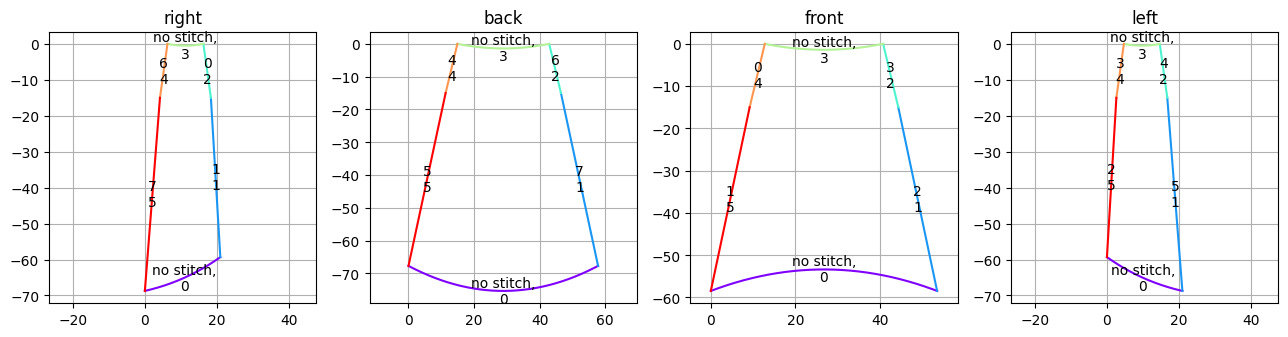

In [ ]:
for garment_name, garment_info in garment_dict.items() :
    print(garment_name)
    for panel_name, panel_info in garment_info["panel_dict"].items() :
        print('\t',panel_name, panel_info["boundary_vert_idx_list"].shape)

print("="*100)

print(garment_name)
print(panel_name)


panel_svg_path_dict = garment_info["panel_svg_path_dict"]
stitch_dict = garment_info["stitch_dict"]


FIGLEN = 4
NCOLS = int(np.sqrt(len(panel_svg_path_dict)))
NROWS = int(np.ceil(len(panel_svg_path_dict) / NCOLS))
NCOLS = 5
NROWS = 3

plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
for i, (panel_name, panel) in enumerate(panel_svg_path_dict.items()):
    ax = plt.subplot(NROWS, NCOLS, i + 1)
    ax.set_title(panel_name)
    plot_panel_info(
        ax, panel_name, panel_svg_path_dict, stitch_dict,
        N_SAMPLES=1000
    )
# plt.savefig(f"{garment_id}_panel_vis.png")
plt.show()

In [146]:
panel_name = list(garment_info["panel_dict"].keys())[3]
panel_info = garment_info["panel_dict"][panel_name]

fig = visualize_meshes_plotly(
    panel_info["panel_mesh"],
    vertices_list=[
        panel_info["panel_mesh"].vertices[
            panel_info["boundary_vert_idx_list"]
        ],
        # panel_dict["panel_mesh"].vertices[:3]
        # panel_dict["panel_mesh"].vertices[boundary_vert_idx_list]
    ],
    vertices_color_list=["red"],
    show_edges=False,
    show=False
)
boundary_vertices = panel_info["panel_mesh"].vertices[panel_info["boundary_vert_idx_list"]]
boundary_indices = panel_info["boundary_vert_idx_list"]


# Add text annotations for each vertex
for i, (vertex, idx) in enumerate(zip(boundary_vertices, boundary_indices)):
    
    fig.add_trace(go.Scatter3d(
        x=[vertex[0]],
        y=[vertex[1]],
        z=[vertex[2]],
        mode='text',
        text=[str(idx)],
        textposition='top center',
        textfont=dict(size=5),
        showlegend=False
    ))

fig.show()
print(panel_info["boundary_vert_idx_list"])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180]


In [ ]:
panel_name = list(garment_info["panel_dict"].keys())[2]
panel_info = garment_info["panel_dict"][panel_name]

list(map(
    lambda x : panel_info["panel_to_garment_idx_map"][x],
    panel_info["boundary_vert_idx_list"]
))

fig2 = visualize_meshes_plotly(
    panel_info["panel_mesh"],
    vertices_list = [
        panel_info["panel_mesh"].vertices[
            panel_info["boundary_vert_idx_list"]
        ]
    ],
    vertices_color_list = ["red"],
    show_edges=False,
)

In [192]:
panel_name = list(garment_info["panel_dict"].keys())[2]
print(panel_name)
panel_info = garment_info["panel_dict"][panel_name]


boundary_vtx_neighbor_segmentation_list = list(map(
    lambda neighbor_vtx_idx_list : list(map(
        lambda x : garment_info["garment_vertex_segmentation_list"][x],
        neighbor_vtx_idx_list
    )) if neighbor_vtx_idx_list is not None else None,
    list(map(
        lambda x : garment_info["overlapping_dict"].get(x, None),
        list(map(
            lambda x : panel_info["panel_to_garment_idx_map"][x],
            panel_info["ordered_boundary_vert_idx_list"]
        ))
    ))
))



Lfront


In [193]:
boundary_vtx_neighbor_segmentation_list

[['Lback', 'Rfront', 'Rback'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['Rfront'],
 ['up_front', 'Rfront'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_front'],
 ['up_back', 'Lback', 'up_front'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],
 ['Lback'],

In [188]:
garment_info["overlapping_dict"].get(-1, "Fuck")

'Fuck'

In [173]:

print(
    list(map(
        lambda x : panel_info["panel_to_garment_idx_map"][x],
        panel_info["boundary_vert_idx_list"]
    ))
)

[73, 75, 77, 79, 82, 83, 85, 87, 90, 91, 93, 96, 98, 99, 101, 104, 106, 107, 109, 111, 113, 116, 118, 120, 122, 124, 126, 127, 129, 131, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3055, 3058, 3060, 3062, 3064, 3066, 3067, 3070, 3071, 3074, 3075, 3078, 3080, 3082, 3084, 3086, 3087, 3090, 3091, 3093, 3095, 3098, 3099, 3102, 3103, 3106, 3107, 3109, 3111, 3113, 3115, 3117, 3119, 3121, 3123, 3125, 3128, 3129, 3132, 3134, 3136, 3137, 3140, 3141, 3144, 3147, 3149, 3152, 3154, 3155, 3158, 3159, 3162, 3163, 3165, 3167, 3169, 3172, 3174, 3176, 3177, 3179, 3182, 3183, 3186, 3188, 3189, 3192, 3193, 3196, 3197, 3199, 3202, 3204, 3206, 3208, 3209, 3211, 3214, 3216, 3217, 3219, 3222, 3224]


In [175]:
garment_info["overlapping_dict"][73]

[74, 71, 72]

In [163]:
print(garment_info["garment_vertex_segmentation_list"])

['Rfront', 'Rback', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rback', 'Rfront', 'Rfront', 'Rback', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rfront', 'Rback', 'Rback', 'Rfront', 'Rfront', 'Rback', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rfront', 'Rback', 'Rback', 'Rfront', 'Rfront', 'Rback', 'Lfront', 'Lback', 'Lfront', 'Rfront', 'Lfront', 'Rfront', 'Lfront', 'Rfront', 'Rfront', 'Lfront', 'Lfront', 'Rfront', 'Lfront', 'Rfront', 'Lfront', 'Rfront', 'Rfront', 'Lfront', 'Lfront', 'Rfront', 'Lfront', 'Rfront', 'Rfront', 'Lfront', 'Rfront', 'Lfront', 'Lfront', 'Rfront', 'Lfront', 'Rf

In [119]:
overlapping_groups

[[12584, 12585],
 [10124, 10125],
 [12674, 12675, 12676, 12677],
 [100, 101],
 [132, 133],
 [9881, 9882],
 [192, 193],
 [12668, 12669],
 [284, 285],
 [12650, 12651],
 [9936, 9937, 9938, 9935],
 [74, 75],
 [5096, 5095],
 [106, 107],
 [166, 167],
 [12642, 12643],
 [226, 227],
 [258, 259],
 [12554, 12555, 12556, 12557],
 [5069, 5070],
 [80, 81],
 [140, 141],
 [5161, 5162],
 [9921, 9922],
 [232, 233],
 [292, 293],
 [9913, 9914],
 [5104, 5103],
 [114, 115],
 [5136, 5135],
 [9896, 9895],
 [206, 207],
 [266, 267],
 [298, 299],
 [9888, 9887],
 [5077, 5078],
 [10098, 10099],
 [12590, 12591],
 [5109, 5110],
 [10232, 10231],
 [9869, 9870],
 [240, 241],
 [10282, 10283],
 [12564, 12565],
 [10072, 10073],
 [5083, 5084],
 [5144, 5143],
 [10164, 10165],
 [214, 215],
 [306, 307],
 [10197, 10198],
 [12616, 12617],
 [5117, 5118],
 [10138, 10139],
 [146, 147],
 [12682, 12683],
 [10112, 10113],
 [10264, 10265],
 [88, 89],
 [120, 121],
 [180, 181],
 [10237, 10238],
 [12656, 12657],
 [10086, 10087],
 [272, 2

In [87]:
import trimesh
import networkx as nx
import numpy as np


ordered_indices = find_and_order_boundary_vertices(
    panel_info["panel_mesh"]
)

print("Ordered boundary vertex indices:", ordered_indices)

Ordered boundary vertex indices: [0, 17, 16, 24, 31, 264, 265, 268, 270, 272, 274, 45, 278, 280, 282, 283, 3, 4, 6, 9, 10, 12, 13, 15, 18, 19, 20, 22, 23, 25, 27, 28, 29, 30, 32, 34, 55, 103, 102, 101, 99, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 67, 79, 78, 77, 76, 75, 72, 70, 73, 51, 56, 57, 60, 61, 64, 66, 71, 21, 98, 232, 41, 236, 58, 144, 100, 243, 180, 210, 198, 253, 259, 224, 258, 244, 255, 26, 214]


In [81]:
# import numpy as np
# import networkx as nx
# from scipy.spatial import KDTree

# def order_boundary_vertices(boundary_vertices, mesh_edges):
#     """
#     Orders the boundary vertices into a circular loop.

#     :param boundary_vertices: (N, 3) array of boundary vertex positions
#     :param mesh_edges: List of (i, j) tuples representing boundary edges
#     :return: Ordered list of boundary vertex indices forming a loop
#     """
#     # Create a graph from boundary edges
#     G = nx.Graph()
#     G.add_edges_from(mesh_edges)

#     # Find a starting point (any degree-1 node should work)
#     start_vertex = list(G.nodes)[0]

#     # Use depth-first search (DFS) or breadth-first search (BFS) to order the loop
#     ordered_indices = list(nx.dfs_preorder_nodes(G, source=start_vertex))

#     return ordered_indices

# # Example usage:
# boundary_vertices = np.array([
#     [0, 0, 0],  # index 0
#     [1, 0, 0],  # index 1
#     [1, 1, 0],  # index 2
#     [0, 1, 0]   # index 3
# ])

# mesh_edges = [(0, 1), (1, 2), (2, 3), (3, 0)]  # Example boundary edges

# ordered_indices = order_boundary_vertices(
#     panel_info["panel_mesh"].vertices[panel_info["boundary_vert_idx_list"]],
#     panel_info["panel_mesh"].edges
# )
# print("Ordered boundary vertex indices:", ordered_indices)

Ordered boundary vertex indices: [186, 34, 185, 152, 29, 30, 32, 184, 28, 247, 27, 25, 194, 155, 123, 136, 200, 111, 104, 1, 122, 187, 103, 55, 102, 188, 101, 99, 277, 275, 95, 96, 97, 199, 94, 257, 93, 92, 178, 227, 256, 148, 217, 105, 216, 190, 117, 143, 134, 161, 18, 19, 20, 193, 22, 246, 23, 245, 219, 15, 171, 13, 254, 12, 206, 165, 10, 9, 6, 252, 203, 4, 163, 3, 283, 201, 162, 202, 282, 280, 251, 139, 118, 126, 167, 212, 45, 278, 274, 156, 195, 270, 248, 131, 113, 281, 106, 192, 112, 191, 2, 226, 153, 273, 91, 90, 89, 181, 271, 150, 182, 87, 88, 86, 85, 240, 151, 261, 107, 5, 69, 127, 168, 213, 16, 24, 31, 264, 220, 172, 221, 140, 119, 7, 263, 262, 267, 260, 239, 145, 173, 265, 268, 17, 157, 196, 214, 249, 132, 114, 269, 14, 109, 74, 128, 169, 215, 259, 224, 258, 244, 174, 141, 223, 120, 108, 146, 222, 175, 255, 26, 253, 158, 197, 210, 250, 133, 115, 121, 129, 170, 242, 236, 58, 144, 100, 176, 231, 177, 147, 142, 225, 243, 180, 41, 159, 204, 232, 98, 42, 21, 205, 71, 164, 66, 211,

In [78]:
np.linalg.norm(
    panel_info["panel_mesh"].vertices[panel_info["boundary_vert_idx_list"][:-1]] - panel_info["panel_mesh"].vertices[panel_info["boundary_vert_idx_list"][1:]],
    axis=1
)


array([12.32232354,  1.23678356,  1.23759753,  1.23755713,  1.23896641,
        1.23975583,  1.2401875 ,  1.2402125 ,  1.24084146,  1.24144677,
        1.24161111,  1.24168418,  1.2411727 ,  1.24178618,  1.24169052,
        1.2421022 ,  1.24110858,  1.23904654,  1.23937167,  1.23906776,
        1.23740452,  1.23658323,  1.23676246,  1.23617556,  1.23567345,
        1.2344924 ,  1.2252456 ,  1.21071118,  1.22793475,  1.19955736,
        1.18070665,  1.18679621,  1.16635191,  1.14328246,  1.16942678,
        1.07210425,  0.68601898, 35.67917628,  1.20286754,  1.24151854,
        1.23617302,  1.23817016,  1.25723174,  1.27367195,  1.27559421,
        1.25483285,  1.25191358,  1.2495038 ,  1.24990963,  1.25101563,
        1.25336044,  1.25306865,  1.24881834,  1.25022232,  1.2505734 ,
        1.24939258,  1.2504672 ,  1.25056373,  1.25109538,  1.2496626 ,
        1.25012018,  1.24968721,  1.2491497 ,  1.24863349,  1.25038638,
        1.25275137,  1.2559859 ,  1.25673702,  1.25820029,  1.25

In [49]:

# IDX = 1551

# IDX = random.randint(0, len(filtered_combination_path_list) - 1)
# combination_path = filtered_combination_path_list[IDX]

# print("IDX :", IDX)
# print("combination_path :", combination_path)

# spec_config_path = os.path.join(combination_path, "static", "spec_config.json")
# with open(spec_config_path, "r") as f:
#     spec_config = json.load(f)

# garment_name_list = list(map(
#     lambda x : os.path.basename(x["spec"].replace("\\", "/")),
#     spec_config.values()
# ))



# with open(os.path.join(combination_path, "static", "static__body_info.json"), "r") as f:
#     static_body_data = json.load(f)
#     betas = torch.tensor(static_body_data['shape'], dtype=torch.float32).unsqueeze(0)
#     pose = torch.tensor(
#         np.deg2rad(static_body_data['pose']),
#         dtype=torch.float32
#     ).unsqueeze(0)  # Shape: (1, 52, 3)
#     transl = torch.tensor(static_body_data['trans'], dtype=torch.float32).unsqueeze(0)

#     body_pose = pose[0, 1:22].reshape(1, -1)  # Body joints (excluding global orientation)
#     left_hand_pose = pose[0, 22:37].reshape(1, -1)  # Left hand joints
#     right_hand_pose = pose[0, 37:52].reshape(1, -1)  # Right hand joints
#     global_orient = pose[0, 0].unsqueeze(0)  # Global orientation

#     # Get body mesh
#     output = model(
#         betas=betas,
#         body_pose=body_pose,
#         global_orient=global_orient,
#         left_hand_pose=left_hand_pose,
#         right_hand_pose=right_hand_pose,
#         # transl=transl
#     )
#     vertices = output.vertices.detach().numpy()[0]
#     faces = model.faces

#     # SCALE = 2 * transl.numpy()[0, 1] / (vertices[:, 1].max() - vertices[:, 1].min())
#     SCALE = 100
#     Z_OFFSET = -3
#     Y_OFFSET = 21

#     static_body_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
#     static_body_mesh.apply_scale(SCALE)

#     static_body_mesh.vertices += transl.numpy()
#     # static_body_mesh.vertices[:, 1] -= static_body_mesh.vertices[:, 1].min()
#     static_body_mesh.vertices[:, 2] += Z_OFFSET
#     static_body_mesh.vertices[:, 1] += Y_OFFSET

# mesh_dict = {}
# garment_dict = {}
# for garment_name in garment_name_list :
#     spec_file_path = os.path.join(
#         combination_path, "static", f"{garment_name}_specification.json"
#     )
#     pattern = pyg.pattern.wrappers.VisPattern(spec_file_path)
#     drawn_pattern_list = list(map(
#         lambda pannel_name : pattern._draw_a_panel(
#             pannel_name, apply_transform=False, fill=True
#         ),
#         pattern.panel_order()
#     ))
#     panel_svg_path_dict = {
#         panel_name : pattern._draw_a_panel(
#             panel_name, apply_transform=False, fill=True
#         )
#         for panel_name in pattern.panel_order()
#     }

#     stitch_dict = {
#         i : v for i, v in enumerate(pattern.pattern['stitches'])
#     }
    
#     mesh = trimesh.load_mesh(os.path.join(
#         combination_path, "static", f"{garment_name}_{garment_name}.obj",
#     ), process=False)

#     neighbor_idx_list = mesh.vertex_neighbors
    
#     with open(
#         os.path.join(
#             # combination_path, "static", f"{garment_name}_{garment_name}_segmentation_filtered.txt"
#             combination_path, "static", f"{garment_name}_{garment_name}_segmentation.txt"
#         ),
#         "r"
#     ) as f:
#         mesh_segmentation_list = list(map(
#             lambda x : x.strip(),
#             f.readlines()
#         ))
#         vertex_mask_dict = {}
#         for panel_name in panel_svg_path_dict.keys() :
#             vertex_mask_dict[panel_name] = np.array(list(map(
#                 lambda x : x == panel_name,
#                 mesh_segmentation_list
#             )))
#         vertex_mask_dict["stitch"] = np.array(list(map(
#             lambda x : x == "stitch",
#             mesh_segmentation_list
#         )))
#         vertex_mask_dict["None"] = np.array(list(map(
#             lambda x : x == "None",
#             mesh_segmentation_list
#         )))

#     fig = visualize_meshes_plotly(
#         [mesh],
#         show_edges=False,
#         # vertices_list = list(map(
#         #     lambda x : mesh.vertices[
#         #         x
#         #     ],
#         #     vertex_mask_dict.values()
#         # ))[:1],
#         # color_list = ["red", "blue", "green", "yellow", "white", "orange", "purple", "pink", "brown", "gray", "black", "white"],
        
#         vertices_list = [
#             mesh.vertices[vertex_mask_dict["stitch"]],
#             mesh.vertices[vertex_mask_dict["None"]],
#         ],
#         vertices_color_list = ["red", "blue"],
#         show=False
#     )
#     fig.show()

#     (
#         panel_mesh_list, panel_segmentation_list,
#         garment_to_panel_idx_map_list, panel_to_garment_idx_map_list
#     ) = disassemble_mesh_to_panels(mesh, mesh_segmentation_list)
    
#     panel_dict = {}
#     for (
#         panel_mesh, panel_segmentation_list, 
#         garment_to_panel_idx_map, panel_to_garment_idx_map
#     )in zip(
#         panel_mesh_list, panel_segmentation_list,
#         garment_to_panel_idx_map_list, panel_to_garment_idx_map_list
#     ) :
#         panel_vertex_mask_dict = {}
#         for panel_name in panel_svg_path_dict.keys() :
#             panel_vertex_mask_dict[panel_name] = np.array(list(map(
#                 lambda x : x == panel_name,
#                 panel_segmentation_list
#             )))
#         panel_vertex_mask_dict["stitch"] = np.array(list(map(
#             lambda x : x == "stitch",
#             panel_segmentation_list
#         )))
#         panel_vertex_mask_dict["None"] = np.array(list(map(
#             lambda x : x == "None",
#             panel_segmentation_list
#         )))
        
#         for panel_name, mask in panel_vertex_mask_dict.items() :
#             print(panel_name, mask.sum())
        
#         fig = visualize_meshes_plotly(
#             panel_mesh,
#             vertices_list = [
#                 panel_mesh.vertices[panel_vertex_mask_dict["stitch"]],
#                 panel_mesh.vertices[panel_vertex_mask_dict["None"]],
#             ],
#             vertices_color_list = ["red", "blue"],
#             show_edges=False,
#             show=False
#         )
#         fig.show()
        
        
#     garment_dict[garment_name] = {
#         "panel_svg_path_dict" : panel_svg_path_dict,
#         "stitch_dict" : stitch_dict,
#         "mesh" : mesh,
#         "panel_mesh_list" : panel_mesh_list,
#         "panel_segmentation_list" : panel_segmentation_list,
#     }
    

In [21]:
list(map(
    lambda x : mesh.vertices[
        x
    ],
    vertex_mask_dict.values()
))


[TrackedArray([[ 71.534477,  79.894379, -30.163786],
               [ 72.194023,  80.347786, -32.65115 ],
               [ 71.373062,  80.751518, -31.604897],
               ...,
               [ 67.776794,  21.107845, -33.875992],
               [ 67.288666,  20.607347, -34.90855 ],
               [ 66.696274,  20.134119, -35.898266]]),
 TrackedArray([[ 60.822735,  75.276833, -15.802821],
               [ 60.283657,  76.008743, -15.494904],
               [ 59.928192,  74.232895, -15.20603 ],
               ...,
               [ 67.23082 ,  60.707123, -34.6385  ],
               [ 66.479416,  40.416161, -35.763733],
               [ 42.37682 ,  53.735226, -43.135204]]),
 TrackedArray([[ 32.54216 ,  59.391609, -34.140446],
               [ 32.799213,  60.520199, -34.097122],
               [ 31.902117,  60.11599 , -34.00824 ],
               ...,
               [ 66.462044,  69.332375, -18.375847],
               [ 67.135773,  72.891144, -18.616676],
               [ 60.794945,  72.543

In [27]:
vertex_mask_dict.keys()

dict_keys(['skirt_back', 'skirt_front', 'top_back', 'top_front'])